# import librairies

In [71]:
import glob
import imageio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import mahotas as mt
from skimage.restoration import estimate_sigma
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
#!conda info --envs

# File reading

In [6]:
X_train_data = pd.read_pickle("data\\df_Xwfilt_train.pickle")
X_test_data = pd.read_pickle("data\\df_Xwfilt_test.pickle")
y_train_data = pd.read_pickle("data\\df_y_train.pickle")
y_test_data = pd.read_pickle("data\\df_y_test.pickle")

In [7]:
X_train_data.head(2)

,ampbw,imsizex,imsizey,edge,gabor
0,"[[121, 121, 121, 122, 128, 131, 132, 132, 131,...",451,1006,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[147, 149, 152, 158, 164, 169, 173, 174, 174,..."
1,"[[87, 83, 82, 82, 79, 53, 43, 39, 37, 37, 37, ...",588,814,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[52, 50, 43, 34, 24, 14, 2, 0, 0, 0, 0, 0, 0,..."


Example images

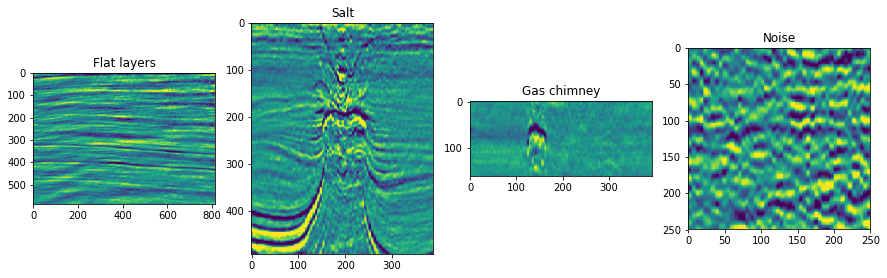

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(X_train_data.loc[1,"ampbw"])
plt.title('Flat layers')
plt.subplot(1,4,2)
plt.imshow(X_train_data.loc[101,"ampbw"])
plt.title('Salt')
plt.subplot(1,4,3)
plt.imshow(X_train_data.loc[170,"ampbw"])
plt.title('Gas chimney')
plt.subplot(1,4,4)
plt.imshow(X_train_data.loc[250,"ampbw"])
plt.title('Noise')
plt.show()

# Feature extraction

Extract features from the images. Each images being filtered with edge detection, gabor, mean

Noise feature

In [10]:
def estimate_noise(img):
    return estimate_sigma(img, multichannel=True, average_sigmas=True)

Mean and standart deviation

In [11]:
def m_std ( img ):
    m = np.mean( img )
    std = np.std( img )
    return ( [m, std] )

Haralick features

In [12]:
def extract_haralick(img):
        # calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(img)
        # take the mean of it and return it
        ht_mean = textures.mean(axis=0)
        return (ht_mean.tolist())

Feature extraction and gathering into a single dataframe

In [16]:
def extract_features(data_frame, image_name, image_type):
    columns_names = ["noise", "mean", "std", "h_1", "h_2", "h_3", "h_4", "h_5", "h_6", "h_7", "h_8",
                                "h_9", "h_10", "h_11", "h_12", "h_13"]
    columns_names = [image_type+"_"+cname for cname in columns_names]
    df = pd.DataFrame(columns = columns_names)
    for idx,img in enumerate(data_frame[image_name]):
        L_ft = [estimate_noise(img), *m_std(img), *extract_haralick(img)]
        df.loc[idx] = L_ft
    return df

In [18]:
def gather_features(dataframe):
    df = pd.DataFrame() # empty dataframe
    images_filters = ["original", "gabor", "edge"]
    images_names = ["ampbw", "edge", "gabor"]
    for i_type in range(len(images_filters)):
        df_new = extract_features(dataframe, images_names[i_type], images_filters[i_type])
        df = pd.concat([df, df_new], axis=1)
    return df

In [20]:
Xfeature_train = gather_features(X_train_data)
Xfeature_train.head(2)

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
Xfeature_test = gather_features(X_test_data)
Xfeature_test.head(2)

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,original_noise,original_mean,original_std,original_h_1,original_h_2,original_h_3,original_h_4,original_h_5,original_h_6,original_h_7,...,edge_h_4,edge_h_5,edge_h_6,edge_h_7,edge_h_8,edge_h_9,edge_h_10,edge_h_11,edge_h_12,edge_h_13
0,2.764494,127.923554,49.277735,0.000364,228.756457,0.952876,2427.388372,0.180961,255.831422,9480.797030,...,11247.244365,0.536538,303.225288,42865.941981,5.792482,8.171281,0.001079,4.193661,-0.269964,0.937759
1,1.978964,126.853128,54.454539,0.000331,187.439783,0.968442,2969.074185,0.193987,253.746483,11688.856956,...,10188.502079,0.482696,303.552641,39467.992958,6.284950,9.104082,0.000853,4.388373,-0.291098,0.969779


In [52]:
df_all_train = pd.concat([X_train_data, Xfeature_train], axis=1)

### Save feartures in a pickle file

In [62]:
Xfeature_train.fillna(0, inplace = True).to_pickle("data\\Xfeature_train.pkl")

In [63]:
Xfeature_test.fillna(0, inplace = True).to_pickle("data\\Xfeature_test.pkl")

### Load features from pickle file

In [64]:
Xfeature_train = pd.read_pickle("data\\Xfeature_train.pkl")

In [65]:
Xfeature_test = pd.read_pickle("data\\Xfeature_test.pkl")

# Feature selection

reduce number of features to save computing time and avoid overfiting

In [66]:
# Feature Extraction with RFE - Recursive feature elimination
num_selected_ft = 15 # Define selected number of features wanted

# feature extraction
model = LogisticRegression()
rfe = RFE(model, num_selected_ft)
fit = rfe.fit(Xfeature_train, y_train_data)
print("Num Features: " + str(fit.n_features_))
print("Selected Features: %s" + str(fit.support_))
print("Feature Ranking: %s"+ str(fit.ranking_))

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.2

Num Features: 15
Selected Features: %s[ True False False False False  True False False False False  True  True
 False  True False False False False False False False  True False False
 False False False False False False False  True  True  True  True False
 False False False False  True False  True  True False  True  True False]
Feature Ranking: %s[ 1  4  3 32 16  1 24  6  5 25  1  1 34  1  2  9 15 11 13 29 18  1 26 31
 12 20 17 23 30 28 10  1  1  1  1 14 19  7 21 22  1 27  1  1 33  1  1  8]


C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warni

In [75]:
selected_features = fit.support_

# Split the data: training / validation

Split randomly between training and validation data: test data have already been keep appart

In [67]:
X_train_ft, X_validation_ft, y_train, y_validation = train_test_split(Xfeature_train, y_train_data, test_size=0.3, random_state=42)

# Model selection

In [96]:
X_train_ft[X_train_ft.columns[selected_features]].head(2)

,original_noise,original_h_3,original_h_8,original_h_9,original_h_11,gabor_h_3,gabor_h_13,edge_noise,edge_mean,edge_std,edge_h_6,edge_h_8,edge_h_9,edge_h_11,edge_h_12
194,1.414944,0.972326,8.099163,11.728458,4.029595,1.000000,0.000000,6.809193,183.282376,77.483483,366.359703,6.995981,10.077986,4.751543,-0.33694
101,1.668407,0.938216,8.317088,12.642823,4.624803,0.339426,0.194686,8.766474,161.515495,89.747358,323.057373,7.144142,10.679388,4.981121,-0.25612


In [97]:
classifiers = {
    "Linear SVM": SVC(),
    "Random forest": RandomForestClassifier(),
    "Neural network": MLPClassifier(random_state = 666),
    "XG_boost": GradientBoostingClassifier()
}

# iterate over classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_ft[X_train_ft.columns[selected_features]], y_train)
    score = clf.score(X_validation_ft[X_validation_ft.columns[selected_features]], y_validation)
    print("{:12} {}".format(name,"-"*15))
    print(classification_report(y_validation, clf.predict(X_validation_ft[X_validation_ft.columns[selected_features]]), digits=3))

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\ipykernel_

Linear SVM   ---------------
              precision    recall  f1-score   support

        flat      0.794     0.844     0.818        32
        gasc      0.600     0.214     0.316        14
        nois      1.000     0.920     0.958        25
        salt      0.393     0.579     0.468        19

   micro avg      0.711     0.711     0.711        90
   macro avg      0.697     0.639     0.640        90
weighted avg      0.736     0.711     0.705        90

Random forest ---------------
              precision    recall  f1-score   support

        flat      0.935     0.906     0.921        32
        gasc      0.579     0.786     0.667        14
        nois      1.000     1.000     1.000        25
        salt      0.733     0.579     0.647        19

   micro avg      0.844     0.844     0.844        90
   macro avg      0.812     0.818     0.809        90
weighted avg      0.855     0.844     0.845        90

Neural network ---------------
              precision    recall  f1-sc

# Build model

Hyper parameter analysis, fit and save the model

In [102]:
parameters = {"learning_rate": [0.01, 0.05, 0.1, 0.2],
                "min_samples_split": np.linspace(0.1, 0.5, 4),
                "min_samples_leaf": np.linspace(0.1, 0.5, 4),
                "max_depth":[3, 5, 8],
#                 "max_features":["log2","sqrt"],
#                 "criterion": ["friedman_mse",  "mae"],
#                 "subsample":[0.5, 0.8, 0.9, 0.95, 1.0],
                "n_estimators":[10, 50]}

rfc = GradientBoostingClassifier()
clf = GridSearchCV(rfc, parameters, iid=False, cv=6, n_jobs=4, verbose=1)
clf.fit(X_train_ft[X_train_ft.columns[selected_features]], y_train )

clf.best_params_
clf.best_estimator_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x1c38a8f44a8 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib\parallel.py", line 375, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib\parallel.py", line 797, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib\parallel.py", line 825, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\qc16\AppData\Local\

Fitting 6 folds for each of 384 candidates, totalling 2304 fits


exception calling callback for <Future at 0x1c38a8f47f0 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib\parallel.py", line 375, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib\parallel.py", line 797, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib\parallel.py", line 825, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\externals\joblib

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2], 'min_samples_split': array([0.1    , 0.23333, 0.36667, 0.5    ]), 'min_samples_leaf': array([0.1    , 0.23333, 0.36667, 0.5    ]), 'max_depth': [3, 5, 8], 'n_estimators': [10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [107]:
choosen_model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.23333333333333334, min_samples_split=0.5,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
choosen_model.fit(X_train_ft[X_train_ft.columns[selected_features]], y_train)

C:\Users\qc16\AppData\Local\Continuum\anaconda3\envs\geocomp\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.23333333333333334, min_samples_split=0.5,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [109]:
y_val_pred = clf.predict(X_validation_ft[X_validation_ft.columns[selected_features]])
print(classification_report(y_validation, y_val_pred, digits=3))

              precision    recall  f1-score   support

        flat      0.967     0.906     0.935        32
        gasc      0.538     0.500     0.519        14
        nois      0.958     0.920     0.939        25
        salt      0.696     0.842     0.762        19

   micro avg      0.833     0.833     0.833        90
   macro avg      0.790     0.792     0.789        90
weighted avg      0.841     0.833     0.835        90



# Prediction analysis

Confusion matrix, classification_report: precision, recall, f1-score

In [110]:
y_val_pred = clf.predict(Xfeature_test[Xfeature_test.columns[selected_features]])
print(classification_report(y_test_data, y_val_pred, digits=3))

              precision    recall  f1-score   support

        flat      0.880     0.957     0.917        23
        gasc      0.857     0.462     0.600        13
        nois      0.917     1.000     0.957        22
        salt      0.750     0.833     0.789        18

   micro avg      0.855     0.855     0.855        76
   macro avg      0.851     0.813     0.816        76
weighted avg      0.856     0.855     0.844        76

